In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from LoadData import loaddata, filter_zeroes

simulation_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'Marvel_JL']
data = loaddata(simulation_names)

inputHistories = np.array([element[0] for element in data])
mass_presentsfr = np.array([element[1] for element in data])

filtered_inputHistories, filtered_mass_presentsfr = filter_zeroes(inputHistories, mass_presentsfr)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(filtered_inputHistories, filtered_mass_presentsfr, test_size=0.2, random_state=42)

# Normalize the star formation histories
X_train = [(sfh / (np.trapz(sfh))) for sfh in X_train]  # Normalize SFH
X_test = [(sfh / (np.trapz(sfh))) for sfh in X_test]    # Normalize SFH

X_train = np.array(X_train)
X_test = np.array(X_test)

# Further split the training data into 80% (64%) training and 20% (16%) validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  

In [90]:
# PyTorch time?!

In [44]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

device = "cpu"
print(f"Using {device} device")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

Using cpu device


**The first 100 SFHs:**

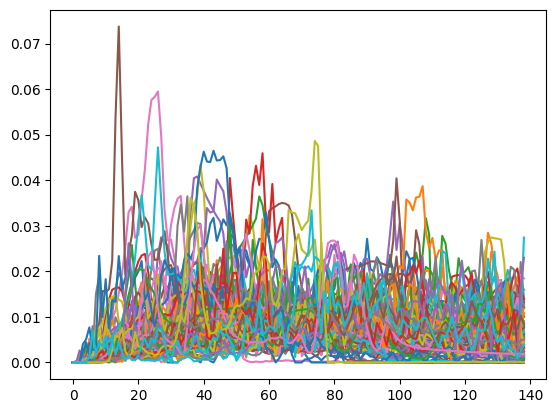

In [45]:
for i in range(100):
    plt.plot(X_train[i])

In [4]:
import torch.optim as optim

# Define the neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Added Conv1d layer
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)  # Added Conv1d layer
        self.pool = nn.MaxPool1d(2, 2)  # Added MaxPool1d layer
        self.fc1 = nn.Linear(64 * 34, 200)  # Adjusted Linear layer input size
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 200)
        self.output = nn.Linear(200, 2)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Added conv1 layer with relu and pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Added conv2 layer with relu and pooling
        x = x.view(-1, 64 * 34)  # Adjusted view to match the new dimensions after convolutions and pooling
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.output(x)
        return x

# Create the model instance
regr = CNN().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming regression task with MSE loss
optimizer = optim.Adam(regr.parameters(), lr=0.001)

# Create a DataLoader for batch processing
dataset = TensorDataset(X_train_tensor.unsqueeze(1), y_train_tensor)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

val_dataset = TensorDataset(X_val_tensor.unsqueeze(1), y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

In [5]:
print(regr)

CNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2176, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=2, bias=True)
)


In [ ]:
# Training loop
num_epochs = 300
losses = [] # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = regr(inputs)
        curr_loss = criterion(outputs, targets)
        curr_loss.backward()
        optimizer.step()
        loss += curr_loss.item()

    loss /= len(dataloader)
    losses.append(loss)
    
    regr.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = regr(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

print('Training complete')

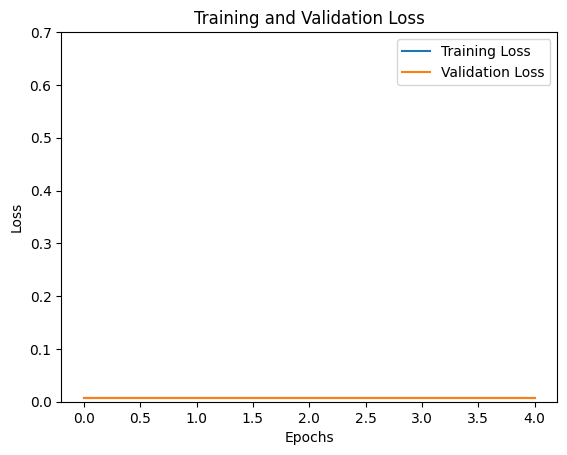

In [140]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.7)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [64]:
torch.save(regr, f'torch{val_losses[-1]}valmodel.pth')

In [46]:
regr = CNN()
regr.load_state_dict(torch.load('CNN Models/torch0.092valmodel.pth'))
print(regr)

CNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2176, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=2, bias=True)
)


In [47]:
with torch.no_grad():
    y_pred_tensor = regr(X_test_tensor.unsqueeze(1))

In [49]:
pred_mass = y_pred_tensor.T[0]
pred_sfr = y_pred_tensor.T[1]

In [50]:
stellar_mass = y_test_tensor.T[0]
star_formation_rate = y_test_tensor.T[1]

Score for log stellar mass: 0.816535472869873
Score for arcsinh SFR: 0.7387136816978455

RMSE for Stellar Mass: 0.2702784836292267 
RMSE for SFR: 0.3378761112689972

Baseline RMSE for Stellar Mass: 0.6310088038444519 (Predicting the mean) 
Baseline RMSE for SFR: 0.6609964966773987 (Predicting the mean)

1,5,10,50,90,95,99 Percentiles for mass residuals: [-0.81167107 -0.41371536 -0.28245258 -0.01091385  0.26077747  0.40818787
  0.81303825]

1,5,10,50,90,95,99 Percentiles for SFR residuals: [-1.19074032 -0.55772746 -0.32857263  0.00584023  0.24194445  0.43684256
  0.97777293]


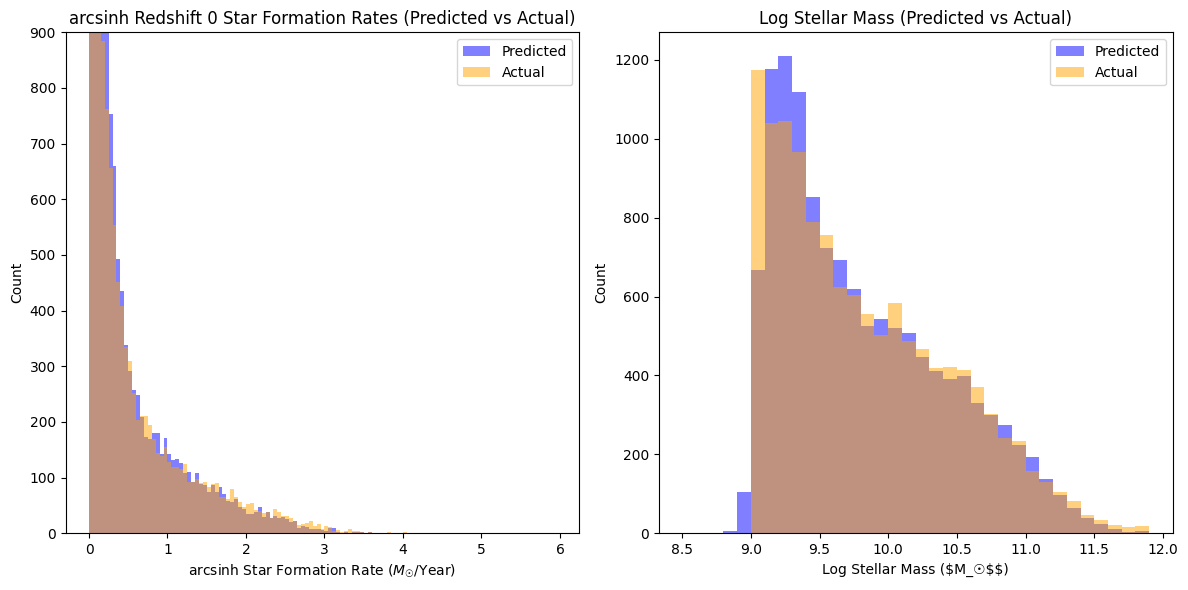

NameError: name 'x' is not defined

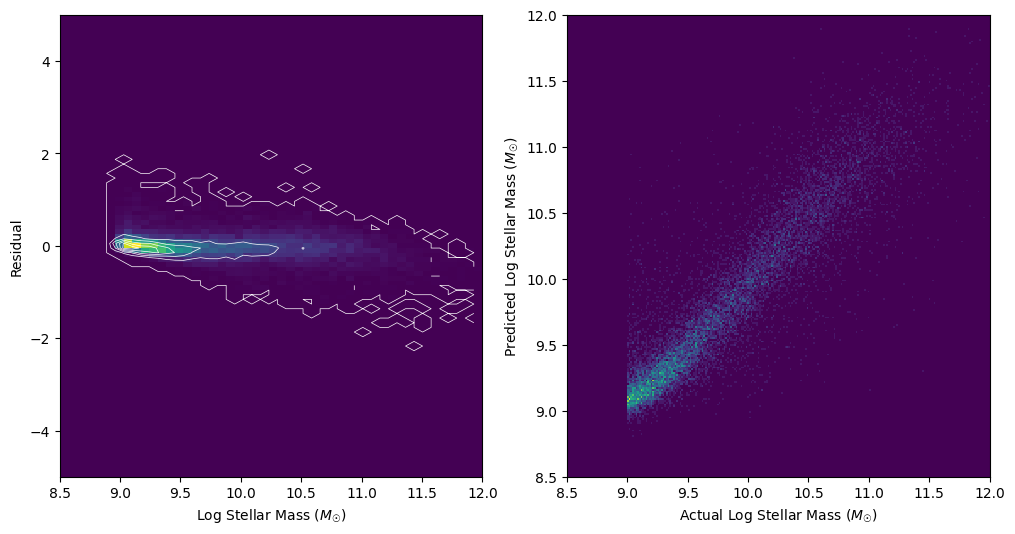

In [60]:
from DataEval import pred_actual_data_eval, pred_actual_data_vis
pred_actual_data_eval(pred_mass, pred_sfr, stellar_mass, star_formation_rate)
pred_actual_data_vis(pred_mass, pred_sfr, stellar_mass, star_formation_rate)